<a href="https://colab.research.google.com/github/Samtomsa/DSF/blob/main/PracticalPartV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MidTerm Project Practical Part** 1:

[2] import all necessary libraries and [12] set path (could might not work here) or [39]

In [ ]:
from pathlib import Path
from warnings import filterwarnings
!pip install rdkit
# Silence some expected warnings
filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import MACCSkeys, Draw
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

# Neural network specific libraries
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 18.3 MB/s eta 0:00:00


In [ ]:
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [39]:
!git clone https://github.com/Samtomsa/DSF.git
%cd DSF
import pandas as pd
data = pd.read_csv('test.csv')

Cloning into 'DSF'...
remote: Enumerating objects: 191, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 191 (delta 33), reused 6 (delta 6), pack-reused 124
Receiving objects: 100% (191/191), 983.37 KiB | 12.45 MiB/s, done.
Resolving deltas: 100% (99/99), done.
/content/DSF/DSF


**Used Functions**

every used function for the talktorial is here
[3] Converts SMILES string to numerical data, so we can use it for a neural network. We use the defined function smiles_to_fp from Talktutorial T007.

In [ ]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.
    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.
    method : str
        The type of fingerprint to use. Default is MACCS keys.
    n_bits : int
        The length of the fingerprint.
    Returns
    -------
    array
        The fingerprint array.
    """

    # Convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        print(f"Warning: Wrong method specified: {method}." " Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

[5] in this function we define a model with two hidden layers.

In [ ]:
def neural_network_model(hidden1, hidden2):
    """
    Creating a neural network from two hidden layers
    using ReLU as activation function in the two hidden layers
    and a linear activation in the output layer.
    Parameters
    ----------
    hidden1 : int
        Number of neurons in first hidden layer.
    hidden2: int
        Number of neurons in second hidden layer.
    Returns
    -------
    model
        Fully connected neural network model with two hidden layers.
    """

    model = Sequential()
    # First hidden layer
    model.add(Dense(hidden1, activation="relu", name="layer1"))
    # Second hidden layer
    model.add(Dense(hidden2, activation="relu", name="layer2"))
    # Output layer
    model.add(Dense(1, activation="linear", name="layer4"))
    
    # Compile model
    model.compile(loss="mean_squared_error", optimizer='adam', metrics=["mse", "mae"])
    return model

Start

Loading Dataset from the Web (could possible also be loaded from Github now with [39])


In [ ]:
# Load the dataset
url = "https://cloud-new.gdb.tools/index.php/s/ZfZM7itQf3rm6Sw/download"
df = pd.read_csv(url, index_col=0)
df = df.reset_index(drop=True)

# Display the first few rows of the dataset
print("Shape of dataframe : ", df.shape)
df.info()

Shape of dataframe :  (179827, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179827 entries, 0 to 179826
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   molecule_chembl_id  179827 non-null  object 
 1   standard_value      179827 non-null  float64
 2   standard_units      179827 non-null  object 
 3   target_chembl_id    179827 non-null  object 
 4   smiles              179827 non-null  object 
dtypes: float64(1), object(4)
memory usage: 6.9+ MB


Data preparation

In [ ]:
# Look at head
df.head()
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,standard_value,standard_units,target_chembl_id,smiles
0,CHEMBL13462,4000.0,nM,CHEMBL1862,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
1,CHEMBL13462,16000.0,nM,CHEMBL1862,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
2,CHEMBL13462,800.0,nM,CHEMBL267,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
3,CHEMBL13462,9000.0,nM,CHEMBL267,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
4,CHEMBL13462,1700.0,nM,CHEMBL267,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...


For the Job needed values are CHEMBL-ID, SMILES and the pIC50 (which we get from the IC50 value) (target needed?)

In [ ]:
# Keep necessary columns
chembl_df = df[["smiles", "target_chembl_id","standard_value"]]
# Convert IC50 to pIC50 (standart_value to the pIC50)
chembl_df['pIC50'] = -np.log10(df['standard_value'] * 1e-9)

chembl_df.replace([np.inf, -np.inf], np.nan, inplace=True)
chembl_df.dropna(inplace=True)

# Print the first few rows of the updated dataframe
chembl_df.head()
# NBVAL_CHECK_OUTPUT

,smiles,target_chembl_id,standard_value,pIC50
0,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,CHEMBL1862,4000.0,5.397940
1,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,CHEMBL1862,16000.0,4.795880
2,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,CHEMBL267,800.0,6.096910
3,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,CHEMBL267,9000.0,5.045757
4,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,CHEMBL267,1700.0,5.769551


[10] Convert SMILES strings to MACCS fingerprints

In [ ]:
chembl_df["fingerprints_df"] = chembl_df["smiles"].apply(smiles_to_fp)
# Print the first few rows of the updated dataframe
chembl_df.head()
# NBVAL_CHECK_OUTPUT

,smiles,target_chembl_id,standard_value,pIC50,fingerprints_df
0,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,CHEMBL1862,4000.0,5.397940,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,CHEMBL1862,16000.0,4.795880,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,CHEMBL267,800.0,6.096910,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,CHEMBL267,9000.0,5.045757,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,CHEMBL267,1700.0,5.769551,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


[11] Split data for train the model. Define x (features) and y (target data)

In [ ]:
# Split the data into training and test set
x_train, x_test, y_train, y_test = train_test_split(
    chembl_df["fingerprints_df"], chembl_df[["pIC50"]], test_size=0.3, random_state=42
)

# Print the shape of training and testing data
print("Shape of training data:", x_train.shape)
print("Shape of test data:", x_test.shape)
# NBVAL_CHECK_OUTPUT

Shape of training data: (125407,)
Shape of test data: (53747,)


[13] Train Model with diffrent sizes of batche's (16,32,64) 

In [ ]:
# Neural network parameters
batch_sizes = [16, 32, 64]
nb_epoch = 50
layer1_size = 64
layer2_size = 32

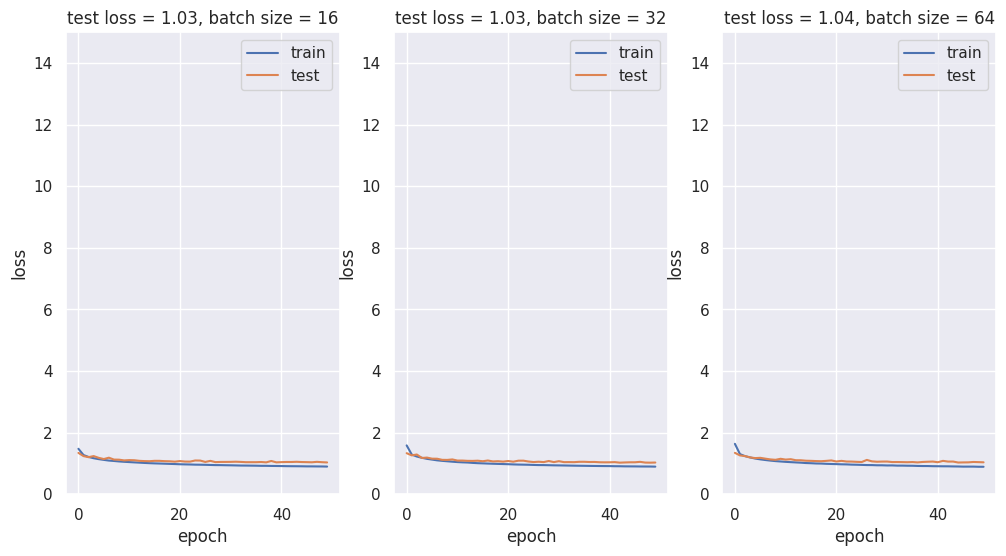

In [ ]:
# Plot
fig = plt.figure(figsize=(12, 6))
sns.set(color_codes=True)
for index, batch in enumerate(batch_sizes):
    fig.add_subplot(1, len(batch_sizes), index + 1)
    model = neural_network_model(layer1_size, layer2_size)

    # Fit model on x_train, y_train data
    history = model.fit(
        np.array(list((x_train))).astype(float),
        y_train.values,
        batch_size=batch,
        validation_data=(np.array(list((x_test))).astype(float), y_test.values),
        verbose=0,
        epochs=nb_epoch,
    )
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="test")
    plt.legend(["train", "test"], loc="upper right")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim((0, 15))
    plt.title(
        f"test loss = {history.history['val_loss'][nb_epoch-1]:.2f}, " f"batch size = {batch}"
    )
plt.show()

[15] saving the best performing model

In [ ]:
# Save the trained model
filepath = DATA / "best_weights.hdf5"
checkpoint = ModelCheckpoint(
    str(filepath),
    monitor="loss",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_weights_only=True,
)
callbacks_list = [checkpoint]

# Fit the model
model.fit(
    np.array(list((x_train))).astype(float),
    y_train.values,
    epochs=nb_epoch,
    batch_size=16,
    callbacks=callbacks_list,
    verbose=0,
)

is not how it should be (<tensorflow.python.keras.callbacks.History at 0x7f3a78556400>) might be a problem later with UBELIX

**Evaluation & prediction on test set**

Test set downloaded from: https://github.com/volkamerlab/teachopencadd/tree/master/teachopencadd/talktorials/T022_ligand_based_screening_neural_network

we have to check if our model does performe. It reports the loss (the Mean Squared Error (MSE): As the name suggests, this loss is calculated by taking the mean of the squared differences between the true and predicted values.) and also the evaluation metrics (the Mean Absolute Error (MAE): The loss is calculated by taking the mean of the absolute difference between the true and predicted values.)

the mean absolute error of our test is below 1, so the given range of pIC50 is low

In [ ]:
# Evalute the model
print(f"Evaluate the model on the test data")
scores = model.evaluate(np.array(list((x_test))), y_test.values, verbose=0)
print(f" loss: {scores[0]:.2f}")
print(f" mse (same as loss): {scores[1]:.2f}")
print(f" mae: {scores[2]:.2f}")


Evaluate the model on the test data
 loss: 1.03
 mse (same as loss): 1.03
 mae: 0.80


In [ ]:
# Predict pIC50 values on x_test data
y_pred = model.predict(np.array(list((x_test))))

# Print 5 first pIC50 predicted values
first_5_prediction = [print(f"{value[0]:.2f}") for value in y_pred[0:5]]

1680/1680 [==============================] - 2s 1ms/step
6.63
5.53
6.86
7.47
6.54


to visualize the predictions, we plot predicted vs true pIC50

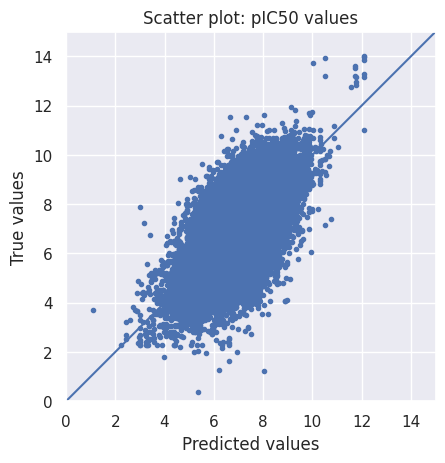

In [ ]:
# Scatter plot
limits = 0, 15
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test, marker=".")
lin = np.linspace(*limits, 100)
ax.plot(lin, lin)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Predicted values")
ax.set_ylabel("True values")
ax.set_title("Scatter plot: pIC50 values")
ax.set_xlim(limits)
ax.set_ylim(limits)
plt.show()

**Prediction on external/unlabeled data**

Import from google drive (could also be done with the [39])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Load external/unlabeled data set
external_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv', index_col=0) 
external_data = external_data.reset_index(drop=True)
external_data.head()
# NBVAL_CHECK_OUTPUT

,canonical_smiles
0,S(Cc1c([O-])c(OC)cc(/C=C(\C#N)/C(=O)N)c1)c1ccccc1
1,S=C(N)N1C(c2ccc(OC)cc2)CC(c2cc(C)c(C)cc2)=N1
2,Clc1c(O)cc(-c2nn(C(C)C)c3ncnc(N)c23)cc1
3,O=C(/C=C/CN1CC[NH+](C)CC1)N1Cc2sc3ncnc(N[C@H](...
4,S(=O)(=O)(NC(=O)Cn1c(C)ncc1[N+](=O)[O-])c1ccc(...


Same function as befor to translate the SMILES to Fingerprint's

In [ ]:
# Convert SMILES strings to MACCS fingerprints
external_data["fingerprints_df"] = external_data["canonical_smiles"].apply(smiles_to_fp)

# Look at head
print("Shape of dataframe : ", external_data.shape)
external_data.head(3)
# NBVAL_CHECK_OUTPUT

Shape of dataframe :  (60, 2)


,canonical_smiles,fingerprints_df
0,S(Cc1c([O-])c(OC)cc(/C=C(\C#N)/C(=O)N)c1)c1ccccc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,S=C(N)N1C(c2ccc(OC)cc2)CC(c2cc(C)c(C)cc2)=N1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Clc1c(O)cc(-c2nn(C(C)C)c3ncnc(N)c23)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
# Load model
model = load_model('/content/drive/MyDrive/Colab Notebooks/ANN_model.hdf5', compile=False)

In [ ]:
# Prediction on external/unlabeled data
predictions = model.predict(
    np.array(list((external_data["fingerprints_df"]))).astype(float), callbacks=callbacks_list
)

predicted_pIC50 = pd.DataFrame(predictions, columns=["predicted_pIC50"])
predicted_pIC50_df = external_data.join(predicted_pIC50)

predicted_pIC50_df.head(3)

2/2 [==============================] - 0s 5ms/step


,canonical_smiles,fingerprints_df,predicted_pIC50
0,S(Cc1c([O-])c(OC)cc(/C=C(\C#N)/C(=O)N)c1)c1ccccc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.779419
1,S=C(N)N1C(c2ccc(OC)cc2)CC(c2cc(C)c(C)cc2)=N1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.483406
2,Clc1c(O)cc(-c2nn(C(C)C)c3ncnc(N)c23)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.343009


In [ ]:
# Save the predicted values in a csv file in the data folder
predicted_pIC50_df.to_csv(DATA / "predicted_pIC50_df.csv")

**top 3 compounds**

In [ ]:
# Select top 3 drugs
predicted_pIC50_df = pd.read_csv(DATA / "predicted_pIC50_df.csv", index_col=0)
top3_drug = predicted_pIC50_df.nlargest(3, "predicted_pIC50")
top3_drug

,canonical_smiles,fingerprints_df,predicted_pIC50
9,Brc1cc(Nc2ncnc3nc(NC)ccc23)ccc1,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,8.481803
53,c1cc(ccc1Nc2c(c(nc[nH+]2)NCCCn3cc[nH+]c3)N)I,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,8.144416
18,Clc1c(F)ccc(NC=2N=CNC=3C=2C=C(OCCCCC=C=C)C(=O)...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,8.120270


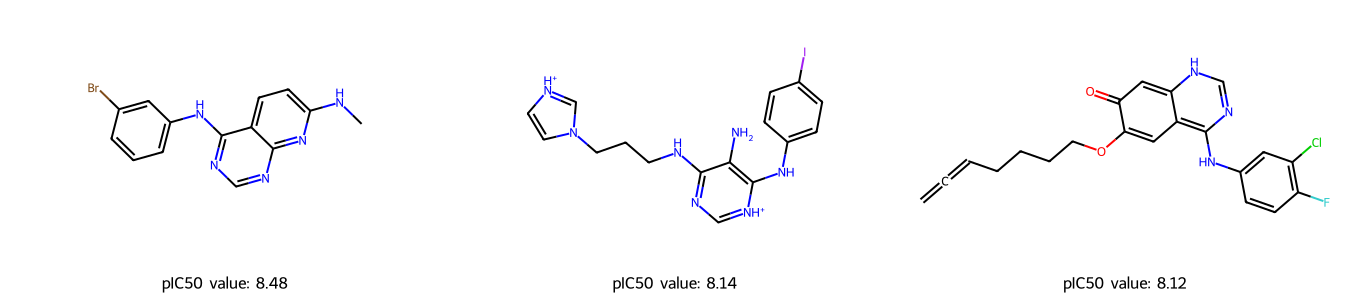

In [ ]:
# Draw the drug molecules
highest_pIC50 = predicted_pIC50_df["canonical_smiles"][top3_drug.index]

mols_EGFR = [Chem.MolFromSmiles(smile) for smile in highest_pIC50]
pIC50_EGFR = top3_drug["predicted_pIC50"].tolist()
pIC50_values = [(f"pIC50 value: {value:.2f}") for value in pIC50_EGFR]

Draw.MolsToGridImage(mols_EGFR, molsPerRow=3, subImgSize=(450, 300), legends=pIC50_values)